In [68]:
# -*- coding: utf-8 -*-
from datetime import datetime, date, timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings("ignore")

# 0 Пару слов об RFM-анализе
**RFM-анализ**– метод исследования особенностей поведения пользователей в процессе покупки,
применяемый при сегментации пользователей, основанный на оценке метрик 
**давности** (R), **частоты** (F) и **суммы затрат на покупки** (M), призванный помочь 
определить клиентов, приносящих больший оборот продукции, GMV, и своевременно 
выявить клиентов, которые потенциально могут уйти в отток

**Recency** — давность покупки — промежуток времени с момента последней покупки. Клиенты, которые покупали недавно, с большей вероятностью купят снова.

**Frequency** — частота покупок — количество покупок за данный период. Вероятность продажи по клиентам будет больше, если человек совершал много покупок.

**Monetary** — сумма покупок — сумма всех покупок за данный период. Клиенты, потратившие на покупки большую сумму денег, вероятнее всего потратят снова.

## Общее описание задачи: 
1) провести RFM анализ с целью выявления кластеров пользователей и оценки текущего состояния интернет-магазина.

2) дать рекомендиции для дальнейшей работы с этими кластерами пользователей.

3) сформировать стратегию коммуникации с каждым из кластеров пользоватей.

# Исходные данные для RFM-анализа

В качетстве исходных данных будем использовать данные о пользователях из интернет-магазина, сгрупированные по четырем столбцам.

**Описание данных:**

user_id - id пользователя

delta_last_order_date - разница между текущей датой и датой последнего заказа (recency)

orders_total - общее число заказов пользователя (Frequency)

gmv_total - значение какой-либо целевой метрики (Monetary)

In [51]:
data = pd.read_csv('rfm_data (1).csv')

In [52]:
data.describe()

,delta_last_order_date,orders_total,gmv_total
count,500000.000000,500000.000000,5.000000e+05
mean,83.467054,118.049134,2.891969e+09
std,52.230729,110.094428,4.740971e+09
min,20.000000,10.000000,1.990450e+05
25%,43.000000,60.000000,7.174699e+08
50%,67.000000,96.000000,1.467198e+09
75%,120.000000,133.000000,3.255968e+09
max,222.000000,6242.000000,5.389788e+11


In [53]:
data.columns

Index(['user_id', 'delta_last_order_date', 'orders_total', 'gmv_total'], dtype='object')

In [54]:
data[['user_id', 'delta_last_order_date', 'orders_total', 'gmv_total']].head()

,user_id,delta_last_order_date,orders_total,gmv_total
0,9dea0a456345c6f66337bdb92934f552,80,183,5960359585
1,8def67d5d76ce2872ac16b7693f10313,189,134,1443155755
2,389381cff07efe5833fac9ede610fea8,113,132,4799903425
3,95a4636240488fda6b7f0498de5924ae,64,88,801619045
4,76978d5e13d9daee315d8d062ed15901,46,21,351221005


Переименуем колонки **delta_last_order_date,orders_total,gmv_total** в более понятный нам вид.

In [55]:
data = data.rename(columns={'delta_last_order_date': 'Recency',
                            'orders_total': 'Frequency', 
                            'gmv_total': 'Monetory'})

Построим гистограммы и посмотрим какие распределение имют наши данные.

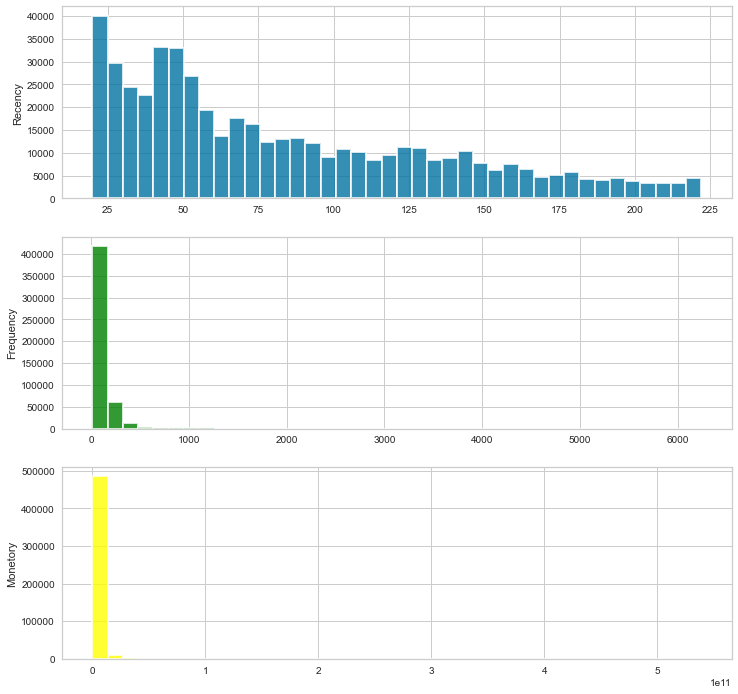

In [56]:
plt.figure(figsize=(12,12))
plt.subplot(311)
data['Recency'].hist(bins=40, alpha=0.8, label='Value', edgecolor='white', linewidth=2)
plt.ylabel('Recency')
plt.subplot(312)
data['Frequency'].hist(bins=40, color = 'green', alpha=0.8, label='Value', edgecolor='white', linewidth=2)
plt.ylabel('Frequency')
plt.subplot(313)
data['Monetory'].hist(bins=40, color = 'yellow', alpha=0.8, label='Value', edgecolor='white', linewidth=2)
plt.ylabel('Monetory')
plt.show()

Из анализа гистограмм видно, что данные приближены к **экспоненциальному распределению**

## Реализуем 2 варианта:
Для решения задачи будем использовать два варианта кластеризации.

Первый - классический квантильный RFM.

Второй - с применением алгоритма KMeans. 
### 1. Квантильный RFM:

Для реализации квантильного RFM будем использовать 4 кластера каждой метрики, т.е. разделим пользователей по каждой метрики на 0.25,0.5,0.75 и 1.0 квантили cоответственно. После чего проведем кластеризацию и добавим метки кластеров к нашему датафрейму, также добавим стобцы RFM_Segment (RFM) и RFM_Score (F + R + M) и проанализируем их показатели.

In [57]:
def rfm_quantile(rfm_data: pd.DataFrame() = None, metrics: list() = None, q: int = 4):
    if rfm_data is None:
        return None
    if metrics is None:
        metrics = rfm_data.columns[1:]
    Recency, Frequency, Monetary = metrics
    rfm_data[metrics] = rfm_data[metrics].dropna().astype('int64')

    labels = range(q, 0, -1)
    rfm_data['R'] = pd.qcut(rfm_data[Recency], q=q, labels=labels).values
    rfm_data['F'] = pd.qcut(rfm_data[Frequency], q=q, labels=labels[::-1]).values
    rfm_data['M'] = pd.qcut(rfm_data[Monetary], q=q, labels=labels[::-1]).values
    rfm_data['RFM_Segment'] = rfm_data.apply(lambda x: str(x['R']) +
                                                       str(x['F']) +
                                                       str(x['M']), axis=1)
    rfm_data['RFM_Score'] = rfm_data[['R', 'F', 'M']].sum(axis=1)
    return rfm_data

In [58]:
rfm_result = rfm_quantile(data, metrics = ['Recency', 'Frequency', 'Monetory'], q = 4)

In [59]:
rfm_result.head()

,user_id,Recency,Frequency,Monetory,R,F,M,RFM_Segment,RFM_Score
0,9dea0a456345c6f66337bdb92934f552,80,183,5960359585,2,4,4,244,10
1,8def67d5d76ce2872ac16b7693f10313,189,134,1443155755,1,4,2,142,7
2,389381cff07efe5833fac9ede610fea8,113,132,4799903425,2,3,4,234,9
3,95a4636240488fda6b7f0498de5924ae,64,88,801619045,3,2,2,322,7
4,76978d5e13d9daee315d8d062ed15901,46,21,351221005,3,1,1,311,5


In [60]:
rfm = rfm_result[['RFM_Score', 'user_id']].groupby(['RFM_Score']).user_id.nunique().reset_index().rename({'user_id': 'users'}, axis = 1)

Построим гистограмму распределния RFM_Score.

<AxesSubplot:xlabel='RFM_Score', ylabel='users'>

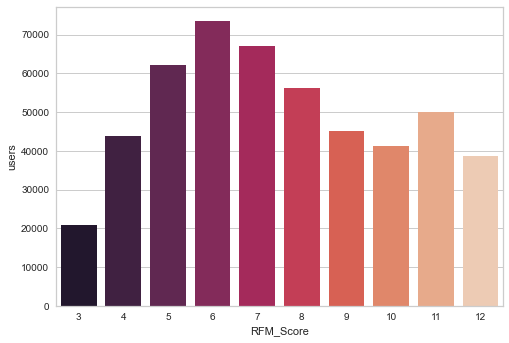

In [61]:
sns.barplot(data = rfm, x = 'RFM_Score', y = 'users', palette = "rocket")

Из анализа гистограммы видим, что количество пользователей с R=F=M=1 мало, что хорошо для нас, то есть в нашем магазине мало пользователей, которые имеют низкую частоту заказов, высокий показатель давности заказа и низкую целевую метрику.

Наибольшее количество пользователей имеют RFM_Score=6, что является средним значением по данной метрике. Однако стоит обратить внимание на этих пользователей и создать им условия для перехода в 7 и последующие группы.

По мере увелечения метрики RFM_Score количество пользователей уменьшается, но большее количество пользователей находится за средним значением RFM_Score. Это является положительным фактором для нашего интернет-магазина.

Посмотрим как распределены пользователи по сегментам. 

In [62]:
rfm_aggr = rfm_result[['user_id', 'R', 'F']].groupby(['R', 'F']).user_id.nunique().reset_index()
rfm_pivot = rfm_aggr.pivot(values = 'user_id', index='R', columns='F')

<AxesSubplot:xlabel='F', ylabel='R'>

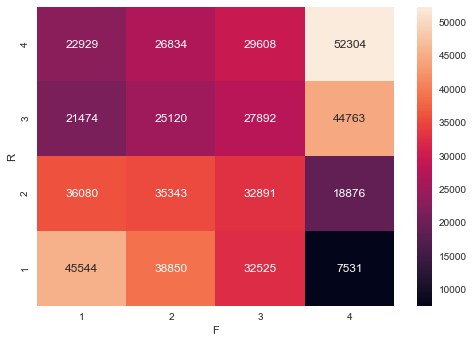

In [63]:
sns.heatmap(rfm_pivot, annot=True, fmt=".0f")

<AxesSubplot:xlabel='F', ylabel='R'>

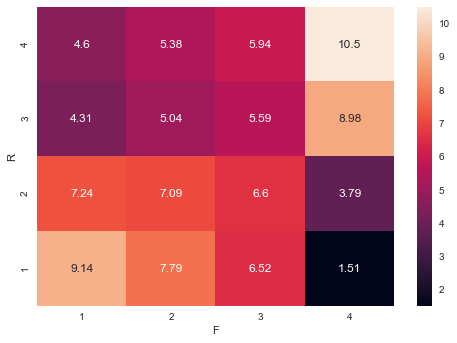

In [64]:
rfm_aggr['users_share'] = rfm_aggr['user_id']*1.0/rfm_aggr['user_id'].sum()*100.0
sns.heatmap(rfm_aggr.pivot(values = 'users_share', index='R', columns='F'), annot=True, fmt=".3g")

Из анализа карты пользователей выделим следующие группы и дадим рекомендации для дальнейшей работы с ними: 

**Отток** - это пользователи, имеющие R=4 и F=1, т.е. они давно заходили в наш магазин и имели мало заказов. Видим, что таких пользователей **~5%**. Это не особо высоких показатель, поэтому отток пользователей не является большим. Однако, менеджеру можно поработать над этими людьми для уменьшения кол-ва данных пользователей.

**Риск**- пользователи имеющие R=3 и F=1. Видно, что их также **~5%**. Для уменьшения доли этих пользователей следуюет рассказать их о наших новых акциях, новых продуктах, т.е. постараться вернуть их обратно и не дать им перейти в группу "оттока".

**Лояльные**-пользователи имеющие R=2 и 1 , F=1. Это пользователи, которые часто посещают наш магазин, но недостаточно часто совершают покупки, если сравнивать с “перспективными” клиентами. Видим, что таких пользователей **~15%**. Таким образом,для увелечения продаж мы можем больше продвигать наш продукт и выпускать более красивый упаковочный продукт.

**Спящие**-пользователи, которые давольно часто пользовались нашим магазином в прошлом. Доля таких пользователей составляет **~20%**. Следует разослать им пуш уведомления о предстоящих акциях, так как есть вероятность, что они вернуться в наш магазин, так как раньше часто покупали здесь.

**Перспективные**-пользователи имеющие R=1 F=2;R=1 F=3;R=2 F=2,R=2 F=3;R=3,F=3;R=3 F=2;R=3 F=4. Данная группа пользователей является наиболее большой и составляет **~50%** от всех пользователей. В дальнейшем мы надеемся, что эти люди станут нашими постоянными клиентами, поэтому стоит уделить им особое внимание. Так как они уже покупали наши продукты, мы можем связаться с ними и предложить какой-либо подарок или предоставить бесплатное обслуживание в течение определнного времени.

**Новые** - пользователи имеющие R=1,2 F=4. Видно, что таких клиентов практически нет, что является нехорошим моментом. Необходимо обратиться к менеджеру по работе с рекламой и сообщить о том, что в наш интернет магазин практически не заходят новые пользователи. После чего сформировать/пересмотреть реклманую компанию.


<AxesSubplot:xlabel='M', ylabel='R'>

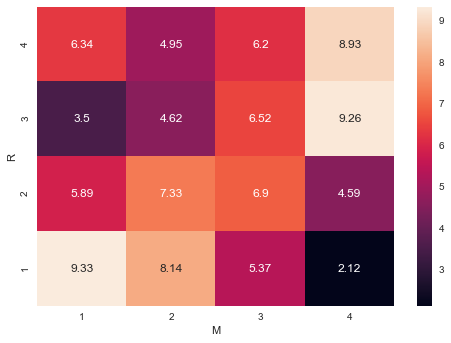

In [65]:
rfm_aggr = rfm_result[['user_id', 'R', 'M']].groupby(['R', 'M']).user_id.nunique().reset_index()
rfm_pivot = rfm_aggr.pivot(values = 'user_id', index='R', columns='M')
#sns.heatmap(rfm_pivot, annot=True, fmt=".0f")
rfm_aggr['users_share'] = rfm_aggr['user_id']*1.0/rfm_aggr['user_id'].sum()*100.0
sns.heatmap(rfm_aggr.pivot(values = 'users_share', index='R', columns='M'), annot=True, fmt=".3g")

RM анализ: 

-кластер пользователей, приносящий высокую прибль достаточно высок (~25%), причем эти пользователи совершают покупки часто (R=3,4)

-имеется группа пользователей с низким показателей прибыли и редкой частотой покупки R=M1 (~10%)

-так же есть группа пользователей (~20%), которые вносят средний вклад в прибль.

Из RM анализа можно сделать вывод, что имеется достаточно большое кол-во пользователей, делающие покупки регуляно на большие чеки, также есть группа пользователей, которые не вносят большого вклада в общуюю прибль.

<AxesSubplot:xlabel='M', ylabel='F'>

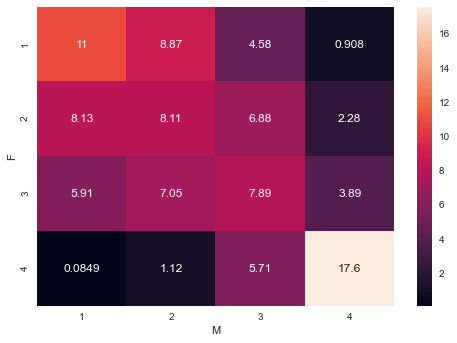

In [67]:
rfm_aggr = rfm_result[['user_id', 'F', 'M']].groupby(['F', 'M']).user_id.nunique().reset_index()
rfm_pivot = rfm_aggr.pivot(values = 'user_id', index='F', columns='M')
#sns.heatmap(rfm_pivot, annot=True, fmt=".0f")
rfm_aggr['users_share'] = rfm_aggr['user_id']*1.0/rfm_aggr['user_id'].sum()*100.0
sns.heatmap(rfm_aggr.pivot(values = 'users_share', index='F', columns='M'), annot=True, fmt=".3g")

FM анализ:

-преобладает группа людей (~18%), которые покупаю часто, на маленькие чеки

-чуть меньше пользователей (~11%), которые покупают редно, но на большие чеки

Из FM анализа видно, что в нашем магазине имеются разные типы пользователей, что следует учитывать при дальнейшей маркетинговой стратегии.

### 2. RFM при помощи kmeans:

Реализуем RFM анализ при помощи kmeans. Но перед этим проведем мнимальную предварительную обработку данных: отмасштабируем данные и выполним их нормализацию. После чего определим количество кластеров для данных и выполним кластеризацию по каждой метрике.

### 2.1. Масштабирование данных:

In [27]:
def scale_data(X_train: pd.DataFrame() = None, 
               metrics: list() = None):
    if X_train is None:
        return None
    if metrics is None:
        metrics = X_train.columns[1:]
    Recency, Frequency, Monetary = metrics  
    X_train_scaled = X_train.copy(deep=True)
    X_train_scaled[metrics[1:]] = X_train_scaled[metrics[1:]].dropna().astype('int64')

    adjust_to_uno = lambda item: 1 if item <= 0 else item
    X_train_scaled[Recency] = X_train_scaled[Recency].apply(adjust_to_uno)
    X_train_scaled[Monetary] = X_train_scaled[Monetary].apply(adjust_to_uno)
    X_train_scaled[metrics] = X_train_scaled[metrics].apply(np.log, axis=1).round(3)
    return X_train_scaled

In [28]:
data_transformed = scale_data(data[['user_id', 'Recency', 'Frequency', 'Monetory']])

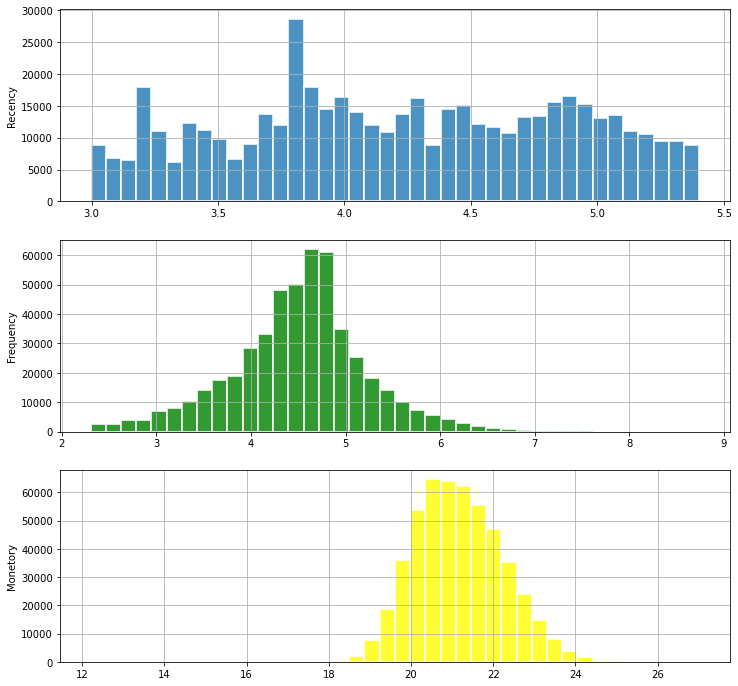

In [29]:
plt.figure(figsize=(12,12))
plt.subplot(311)
data_transformed['Recency'].hist(bins=40, alpha=0.8, label='Value', edgecolor='white', linewidth=2)
plt.ylabel('Recency')
plt.subplot(312)
data_transformed['Frequency'].hist(bins=40, color = 'green', alpha=0.8, label='Value', edgecolor='white', linewidth=2)
plt.ylabel('Frequency')
plt.subplot(313)
data_transformed['Monetory'].hist(bins=40, color = 'yellow', alpha=0.8, label='Value', edgecolor='white', linewidth=2)
plt.ylabel('Monetory')
plt.show()

### 2.2. Нормализация данных:

In [30]:
def normalize_data(X_train: pd.DataFrame() = None, metrics: list() = None, name: str = ''):
    if X_train is None:
        return None
    if metrics is None:
        metrics = X_train.columns[1:]
    X_train_scaled = X_train.copy(deep=True)
    X_train_scaled[metrics] = X_train_scaled[metrics].astype('int64')

    imputer = SimpleImputer(missing_values=np.nan, strategy='median')
    scaler = StandardScaler() 
    pipe = Pipeline([('imputer', imputer), ('scaler', scaler)])

    X_train_scaled[metrics] = pd.DataFrame(data=pipe.fit_transform(X_train_scaled[metrics]),
                                               columns=metrics)
    return X_train_scaled

In [31]:
data_transformed = normalize_data(data_transformed[['user_id', 'Recency', 'Frequency', 'Monetory']])

In [32]:
data_transformed.describe()

,Recency,Frequency,Monetory
count,5.000000e+05,5.000000e+05,5.000000e+05
mean,4.668808e-15,-1.741877e-15,-3.344933e-16
std,1.000001e+00,1.000001e+00,1.000001e+00
min,-2.485259e+00,-2.583610e+00,-7.867663e+00
25%,-1.049644e+00,2.131086e-02,-6.130342e-01
50%,3.859709e-01,2.131086e-02,2.937943e-01
75%,3.859709e-01,2.131086e-02,2.937943e-01
max,1.821586e+00,5.231154e+00,5.734766e+00


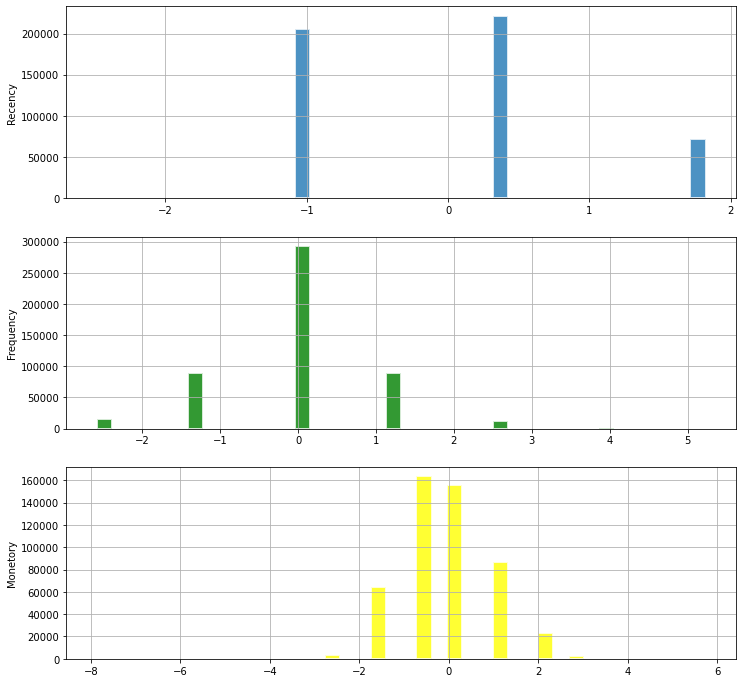

In [33]:
plt.figure(figsize=(12,12))
plt.subplot(311)
data_transformed['Recency'].hist(bins=40, alpha=0.8, label='Value', edgecolor='white', linewidth=2)
plt.ylabel('Recency')
plt.subplot(312)
data_transformed['Frequency'].hist(bins=40, color = 'green', alpha=0.8, label='Value', edgecolor='white', linewidth=2)
plt.ylabel('Frequency')
plt.subplot(313)
data_transformed['Monetory'].hist(bins=40, color = 'yellow', alpha=0.8, label='Value', edgecolor='white', linewidth=2)
plt.ylabel('Monetory')
plt.show()

In [34]:
data_transformed.head()

,user_id,Recency,Frequency,Monetory
0,9dea0a456345c6f66337bdb92934f552,0.385971,1.323772,1.200623
1,8def67d5d76ce2872ac16b7693f10313,1.821586,0.021311,0.293794
2,389381cff07efe5833fac9ede610fea8,0.385971,0.021311,1.200623
3,95a4636240488fda6b7f0498de5924ae,0.385971,0.021311,-0.613034
4,76978d5e13d9daee315d8d062ed15901,-1.049644,-1.281150,-1.519863


### 2.3. Определение количества кластеров

In [35]:
def wcss(rfm_data: pd.DataFrame() = None, metrics: list() = None):
    if rfm_data is None:
        return None
    if metrics is None:
        metrics = rfm_data.columns

    wcss = {}
    for k in range(1, 11):
        kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300)
        kmeans.fit(rfm_data)
        wcss[k] = kmeans.inertia_
    # plot the WCSS values
    sns.pointplot(x=list(wcss.keys()), y=list(wcss.values()))
    plt.xlabel('K Numbers')
    plt.ylabel('WCSS')
    plt.show()
    return

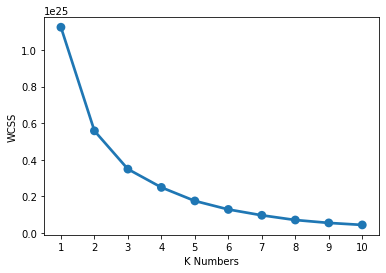

In [36]:
wcss(data[['Recency', 'Frequency', 'Monetory']])

### 2.4. Определение количества кластеров при помощи билиотеки YellowBrick:

In [148]:
#!pip install yellowbrick

KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_fast._relocate_empty_clusters_dense'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 2, in where
KeyboardInterrupt: 


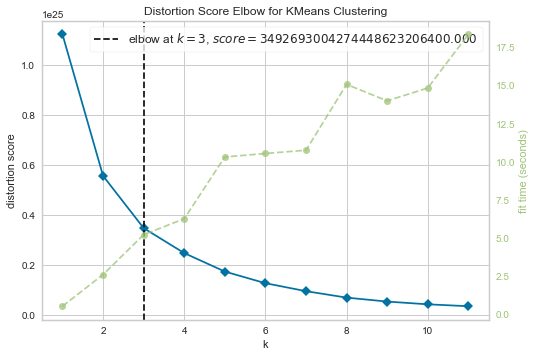

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [48]:
from yellowbrick.cluster import KElbowVisualizer
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,12))
visualizer.fit(data[['Recency', 'Frequency', 'Monetory']]) # Fit the data to the visualizer
visualizer.show() # Finalize and render the figure

### 2.5. Сегментация при помощи K-Means:

In [37]:
#rfm_knn
def rfm_knn(rfm_data: pd.DataFrame() = None, metrics: list() = None, name: str = '', n_clusters: int = 4):
    if rfm_data is None:
        return None
    if metrics is None:
        metrics = rfm_data.columns[1:]
    # Сlustering
    Recency, Frequency, Monetary = metrics

    kmeans_clusters = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=300, random_state=0)
    kmeans_clusters.fit(rfm_data[[Recency]].dropna().astype('int64'))
    rfm_data['R_Cluster'] = kmeans_clusters.labels_+1

    kmeans_clusters = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=300, random_state=0)
    kmeans_clusters.fit(rfm_data[[Frequency]].dropna().astype('int64'))
    rfm_data['F_Cluster'] = kmeans_clusters.labels_+1

    kmeans_clusters = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=300, random_state=0)
    kmeans_clusters.fit(rfm_data[[Monetary]].dropna().astype('int64'))
    rfm_data['M_Cluster'] = kmeans_clusters.labels_+1

    kmeans_clusters = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=300, random_state=0)
    kmeans_clusters.fit(rfm_data[metrics].dropna().astype('int64'))
    # Assign the clusters to data
    rfm_data['K_Cluster'] = kmeans_clusters.labels_+1
    return rfm_data

In [43]:
result = rfm_knn(data_transformed[['user_id', 'Recency', 'Frequency', 'Monetory']])

In [44]:
result.head()

,user_id,Recency,Frequency,Monetory,R_Cluster,F_Cluster,M_Cluster,K_Cluster
0,9dea0a456345c6f66337bdb92934f552,0.385971,1.323772,1.200623,2,1,3,2
1,8def67d5d76ce2872ac16b7693f10313,1.821586,0.021311,0.293794,3,2,1,4
2,389381cff07efe5833fac9ede610fea8,0.385971,0.021311,1.200623,2,2,3,2
3,95a4636240488fda6b7f0498de5924ae,0.385971,0.021311,-0.613034,2,2,1,4
4,76978d5e13d9daee315d8d062ed15901,-1.049644,-1.281150,-1.519863,1,3,4,3


In [45]:
rfm_aggr = result[['user_id', 'R_Cluster', 'F_Cluster']].groupby(['R_Cluster', 'F_Cluster']).user_id.nunique().reset_index()
rfm_pivot = rfm_aggr.pivot(values = 'user_id', index='R_Cluster', columns='F_Cluster')
rfm_pivot

F_Cluster,1,2,3,4
R_Cluster,,,,
1,70650,104080,24639,3650
2,26192,140907,45526,8328
3,1673,46465,19430,4146
4,104,63,10,2


<AxesSubplot:xlabel='F_Cluster', ylabel='R_Cluster'>

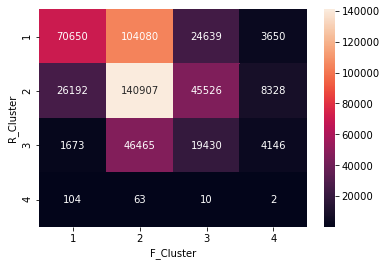

In [46]:
sns.heatmap(rfm_pivot, annot=True, fmt=".0f")

<AxesSubplot:xlabel='F_Cluster', ylabel='R_Cluster'>

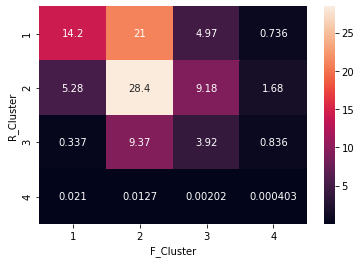

In [47]:
rfm_aggr['users_share'] = rfm_aggr['user_id']*1.0/rfm_aggr['user_id'].sum()*100.0
sns.heatmap(rfm_aggr.pivot(values = 'users_share', index='R_Cluster', columns='F_Cluster'), annot=True, fmt=".3g")

Проанализируем каруту пользователей при использовании алгиритма кластеризации kmeans:

-процентное соотношение пользователей в каждом из кластеров поменялось, однако при рассмотрении пользователей 'по группам' их соотношении практически не изменилось:

а) кол-во спящих пользователей составляет ~26% (квантильный RFM: ~%)

б) кол-во пользователей оттока составляет ~14% (квантильный RFM: ~%)

в) кол-во пользователей группы риска состоялвет ~5% (квантильный RFM: ~%)

г) кол-во лояльных пользователей ~0.5%! (квантильный RFM: ~%)

д) кол-во перспективынх пользователей ~52% (квантильный RFM: ~%)
 
e) кол-во новых пользователей ~1% (квантильный RFM: ~%)

Видим, что значительная разница по сравнению с квантильным RFM проявляется только в группе лояльных пользователей. Остальные группы имеют такое же соотношение пользователей, как и в первом варианте кластеризации. Таким образом, можно для данного случая можно дать аналогичные рекомендации, что были представленны выше.

### Вывод.

В целом, наш магазин находится в благополочном состоянии: имеется большая доля потенциальных клиентов, которые в дальнейшем могут стать нашими постоянными клиентами.

Однако, очень мало значение новых пользователей. Необходимо поработать над их привлечением.

Количество пользователей оттока и риска не особо большое, но нужно парботать с ними, чтобы вернуть клиентов обратно.

Чуть больше спящих клентов, для них также необходимо предпринять действия для того,чтобы они перешли в группу постоянных клиентов.